**0. Import the relevant libraries and packages** 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 999

**Code by:** 

Santiago Guardo & Ricardo Pizarro

**Supervision:** 

Ricardo Pizarro and Silvia Lopez

# 1. Input

We need the parameters (alpha and beta) for gains AND losses from the utility model. 
-  These can be retrieved using participant's data and running the model. 
-  Or, with ADO algorithm


**1.1 First visit input:**

Run the model and retrieve the parameters from the CSV called 'split_CRDM_analysis.csv'. The exact pathway will vary according to the specific project. This pathway is for the IDM project. 

In [94]:
'''
#participant_code = input ("")
path = '/Volumes/UCDN/datasets/IDM/'
participant_code = '23_IDM_0021'
print('the Participant Code is ' + participant_code)
#MAC path to the File share
participant_split_dir = os.path.join(path,'split') 
participant_trials = os.path.join(participant_split_dir,'{}/crdm/{}_crdm.csv').format(participant_code,participant_code) #This is the psychopy output CSV.We will use it to retrieve the probabilities and image files. 

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CRDM_analysis.csv')
parameters = pd.read_csv(utility_analysis)
amb_options = [0.24, 0.5, 0.74]

print('loading fn: {}'.format(participant_trials))
print('loading fn: {}'.format(utility_analysis))
'''

'\n#participant_code = input ("")\npath = \'/Volumes/UCDN/datasets/IDM/\'\nparticipant_code = \'23_IDM_0021\'\nprint(\'the Participant Code is \' + participant_code)\n#MAC path to the File share\nparticipant_split_dir = os.path.join(path,\'split\') \nparticipant_trials = os.path.join(participant_split_dir,\'{}/crdm/{}_crdm.csv\').format(participant_code,participant_code) #This is the psychopy output CSV.We will use it to retrieve the probabilities and image files. \n\n#Path to the utility model data\nutility_dir = os.path.join(path,\'utility\')\nutility_analysis = os.path.join(utility_dir,\'split_CRDM_analysis.csv\')\nparameters = pd.read_csv(utility_analysis)\namb_options = [0.24, 0.5, 0.74]\n\nprint(\'loading fn: {}\'.format(participant_trials))\nprint(\'loading fn: {}\'.format(utility_analysis))\n'

**1.2 ADO input**

ADO gives as an output a CSV, whose last row has the best model fit parameters. 

In [95]:
#First, let's read the ADO output for gains and losses and make it DataFrames
patient_code = 'NIH_ADO_sample' #This is to keep the CSV in the same directories as the patient's data
ado_out_gain = '/Volumes/UCDN/datasets/ICR/ado/sample_output_gain.csv'
ado_out_loss = '/Volumes/UCDN/datasets/ICR/ado/sample_output_loss.csv'
ado_out_gain_df = pd.read_csv(ado_out_gain, index_col=None)
ado_out_loss_df = pd.read_csv(ado_out_loss, index_col=None)

#Now, we extract the last row of the ADO. Those are going to be our parameters
ado_gain_last_row = ado_out_gain_df.iloc[[-1]] 
ado_loss_last_row = ado_out_loss_df.iloc[[-1]] 

#Parameters for the gains
alpha_pos, beta_pos = ado_gain_last_row[['mean_alpha','mean_beta']].values[0]

#Parameters for the losses
alpha_neg, beta_neg = ado_loss_last_row[['mean_alpha','mean_beta']].values[0]

#Declare the variables
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
amb_options = [0.24, 0.5, 0.74]
A_null = 0.0 # no ambiguity
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
Vsafe_pos = 5.0 # The old safe option in positive trials
Vsafe_neg = -5.0 # The old safe option in negative trials

# used for populating trials
empty_df = pd.DataFrame([],columns=['category','p_reward', 'value_reward'])



# 2. Creating the choice set
From the Subjective Value formula, we can calculate new values:
# $SV = (p - \beta \cdot \frac{A}{2}) \cdot V^\alpha$ --->  $V = \left(\frac{SV}{p-\frac{\beta A}{2}}\right)^\frac{1}{\alpha}$






**For each probability level:**
- We want to make 3 trials around the point of subjective equality. 

- We want 2 extreme trials. 
  -  Winning $50 for each probability level
  -  Loosing $50 for each probability level
  - 

- We want 4 intermediate trials.  


In [96]:
#Create the extreme positive gains and losses

def get_extreme(p_options,trials='gains'):
    extr = {} #Create an empty dict
    V = Vmax
    if trials=='losses': #If trials are losses, assign them -50
        V = Vmin
    for p in p_options: #Iterate through the probability levels
        extr[p] = V #Assign them the 50 dollars value
    return extr

extrpos = get_extreme(p_options)
print('Gain trials with the maximum Reward: \n', extrpos)

extrneg = get_extreme(p_options,trials='losses')
print('\nLoss trials with the maximum loss: \n', extrneg)



Gain trials with the maximum Reward: 
 {0.75: 50.0, 0.5: 50.0, 0.38: 50.0, 0.25: 50.0, 0.13: 50.0}

Loss trials with the maximum loss: 
 {0.75: -50.0, 0.5: -50.0, 0.38: -50.0, 0.25: -50.0, 0.13: -50.0}


In [97]:
#From the dictionaries, we create DataFrames to work with
def get_extr_df(extr_dict,trials='gains'):
    df_app = pd.DataFrame(extr_dict.items(), columns=['p_reward', 'value_reward'])
    Extr_df = pd.concat([empty_df, df_app], ignore_index=True)
    category = 'Extr_pos'
    if trials=='losses':
        category = 'Extr_neg'
    Extr_df['category'] = category
    Extr_df['ambiguity'] = A_null
    return Extr_df

def add_ambig_extr(df,amb_options,Vmax=50,prob_amb=0.50,trials='gains'):
    amb_dict = {prob_amb:amb_options}
    df_app = pd.DataFrame(amb_dict.items(), columns=['p_reward', 'ambiguity'])
    df_app = df_app.explode('ambiguity')
    df_app['category'] = df['category']
    df_app['value_reward'] = Vmax
    df = pd.concat([df,df_app],ignore_index=True)
    return df

# df_app = pd.DataFrame(centrials_neg.items(), columns=['p_reward', 'value_reward'])
# df_app = df_app.explode('value_reward')

#We define a function to calculate the SV of the trials given the 
#participant's alpha and beta

def append_SVreward(df,alpha,beta,trials='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_reward'] = (df['p_reward'] - beta*df['ambiguity']/2)*Amp*(abs(df['value_reward']))**alpha
    return df

#We define a function to calculate the SV of the safe options of the trials given the 
#participant's alpha and beta

def append_Vsafe(df,alpha,beta,trials='gains'): 
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_New_Safe'] = 0.5*df['SV_reward']
    df['value_lott_SE'] = Amp*(abs(df['SV_New_Safe']) / (df['p_reward']-beta*df['ambiguity']/2)) ** (1 / alpha)
    df['value_safe'] = Amp*(abs(df['SV_New_Safe'])) ** (1 / alpha)
    return df

#Define the data frames
df_pos = get_extr_df(extrpos)
df_pos = add_ambig_extr(df_pos,amb_options)

df_neg = get_extr_df(extrneg,trials='losses')
df_neg = add_ambig_extr(df_neg,amb_options,Vmax=Vmin,trials='losses')


#Add the SV of reward and safe trials
df_pos = append_SVreward(df_pos,alpha_pos,beta_pos)
df_neg = append_SVreward(df_neg,alpha_neg,beta_neg,trials='losses')

df_pos = append_Vsafe(df_pos,alpha_pos,beta_pos)
df_neg = append_Vsafe(df_neg,alpha_neg,beta_neg,trials='losses')

# Safe option dataframe to use when merging multiple dataframes
df_safe_pos = df_pos[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()
df_safe_neg = df_neg[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()

In [98]:
#Define the trials of subjective equality

#For gains
df_SE_pos = df_pos[['category','p_reward','ambiguity','value_lott_SE', 'SV_New_Safe']].copy()
df_SE_pos['category'] = 'SE_pos'
df_SE_pos = df_SE_pos.rename(columns={'value_lott_SE':'value_reward'})
#df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
df_SE_pos['value_safe'] = df_safe_pos['value_safe']
df_SE_pos = df_SE_pos.rename(columns={'SV_New_Safe':'SV_reward'})
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])

#For losses
df_SE_neg = df_neg[['category','p_reward','ambiguity','value_lott_SE', 'SV_New_Safe']].copy()
df_SE_neg['category'] = 'SE_neg'
df_SE_neg = df_SE_neg.rename(columns={'value_lott_SE':'value_reward'})
#df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
df_SE_neg['value_safe'] = df_safe_neg['value_safe']
df_SE_neg = df_SE_neg.rename(columns={'SV_New_Safe':'SV_reward'})
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])

In [99]:
#Centered around SE

#For gains
df_cent_pos= df_SE_pos.copy()

df_cent_pos['category'] = 'Cent_SE_pos'
#df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
#df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df_adjusted_pos = df_cent_pos.copy()
df_adjusted_pos['value_reward'] = df_adjusted_pos['value_reward'] +2.0

df_adjusted_neg = df_cent_pos.copy()
df_adjusted_neg['value_reward'] = df_adjusted_neg['value_reward'] - 2.0
df_cent_pos = pd.concat([df_cent_pos, df_adjusted_pos, df_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)

#For losses
#For gains
df_cent_neg= df_SE_neg.copy()

df_cent_neg['category'] = 'Cent_SE_neg'
#df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
#df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df1_adjusted_pos = df_cent_neg.copy()
df1_adjusted_pos['value_reward'] = df1_adjusted_pos['value_reward'] +2.0

df1_adjusted_neg = df_cent_neg.copy()
df1_adjusted_neg['value_reward'] = df1_adjusted_neg['value_reward'] - 2.0
df_cent_neg = pd.concat([df_cent_neg, df1_adjusted_pos, df1_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_neg = append_SVreward(df_cent_neg,alpha_neg,beta_neg,trials='losses')


In [100]:
df_int_temp = df_pos.copy()
df_int_temp['category'] = 'Int_pos'
def get_interm(df,df_safe_pos,beta,alpha,num_steps=2, trials = 'gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    dfreturn = pd.DataFrame([], columns = list(df))
    df['SVrange'] = df['SV_reward'] - df['SV_New_Safe']
    df['SVstep'] =  df['SVrange']/(num_steps+1)
    list_x = [i for i in range(-num_steps-1,num_steps+1) if i != 0]
    
    for x in list_x:
        dfint = df[['category', 'p_reward','ambiguity']].copy()
        if x == -num_steps-1:
            dfint['category'] = 'Zero_Reward'
        dfint['SV_reward'] = df['SV_New_Safe'] + x*df['SVstep']
        dfint['value_reward'] = Amp*(abs(dfint['SV_reward']) / (dfint['p_reward']-beta*dfint['ambiguity']/2)) ** (1 / alpha)
        dfint = pd.merge(dfint,df_safe_pos,on=['p_reward','ambiguity'])
        dfreturn= pd.concat([dfreturn,dfint],ignore_index=True)

    return dfreturn

df_int_pos = get_interm(df_int_temp, df_safe_pos, beta_pos,alpha_pos, num_steps=2)


In [101]:
df_intneg_temp = df_neg.copy()
df_intneg_temp['category'] = 'Int_neg'
df_int_neg = get_interm(df_intneg_temp, df_safe_neg, beta_neg,alpha_neg, num_steps=2,trials='losses')


# concat three dataframes
CentTrials trials centered around Subjective Equality
ExtrPos trials in the extreme where value reward is $50
IntPor trials in between along range (SE and SVmax)

In [102]:
df_Trials_gains = pd.concat([df_pos,df_int_pos,df_cent_pos],ignore_index=True)
df_Trials_gains['SV_New_Safe'] = df_Trials_gains['value_safe']**alpha_pos
df_Trials_gains['deltaSV'] = df_Trials_gains['SV_reward'] - df_Trials_gains['SV_New_Safe']
df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])

#Convert selected columns to numeric values to be able to round
columns_to_convert = ['value_reward', 'value_safe', 'SV_reward', 'SV_New_Safe', 'deltaSV']
df_Trials_gains[columns_to_convert] = df_Trials_gains[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_Trials_gains = df_Trials_gains.round(2)


In [103]:
import math
desired_trials = 72

# Check if the current number of trials is less than the desired number

if len(df_Trials_gains) < desired_trials:
    
    trials_needed = desired_trials - len(df_Trials_gains)
    
    # Calculate the number of additional trials for each category (gains and losses)
    trials_needed_gains = math.ceil(trials_needed)  # Round up to the nearest integer

    # Add new trials from the extremes reward or loss
    additional_trials_gains = df_pos.sample(n=trials_needed_gains, replace=True)

    # Concatenate the additional trials to your existing DataFrame
    df_Trials_gains = pd.concat([df_Trials_gains, additional_trials_gains], ignore_index=True)
    df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])

# Check if the current number of trials is greater than desired trials
if len(df_Trials_gains) > desired_trials:
    trials_to_delete = len(df_Trials_gains) - desired_trials
    
    # Randomly sample rows to delete
    rows_to_delete = df_Trials_gains[df_Trials_gains['category'] == 'Cent_SE_pos'].sample(n=trials_to_delete)
    
    # Remove the sampled rows from the DataFrame
    df_Trials_gains = df_Trials_gains.drop(rows_to_delete.index)

#Rounding to the nearest 50 cents
df_Trials_gains['value_reward'] = df_Trials_gains['value_reward'].apply(lambda x: round(x * 2) / 2)
df_Trials_gains['value_safe'] = df_Trials_gains['value_safe'].apply(lambda x: round(x * 2) / 2)


#Update value_safe and value_reward when it's 0. Note that the SV_reward for those trials will stay as previously calculate as 0.0
df_Trials_gains.loc[df_Trials_gains['value_safe']==0, 'value_safe'] = 0.5
df_Trials_gains.loc[df_Trials_gains['value_reward']==0, 'value_reward'] = 0.5
df_Trials_gains


,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_safe,deltaSV
0,Extr_pos,0.75,50.0,0.0,4.44,2.22,6.0,2.22
1,Extr_pos,0.50,50.0,0.0,2.96,1.48,2.5,1.48
2,Extr_pos,0.38,50.0,0.0,2.25,1.12,1.5,1.12
3,Extr_pos,0.25,50.0,0.0,1.48,0.74,0.5,0.74
4,Extr_pos,0.13,50.0,0.0,0.77,0.38,0.5,0.38
5,Extr_pos,0.50,50.0,0.24,2.24,1.12,1.5,1.12
6,Extr_pos,0.50,50.0,0.5,1.46,0.73,0.5,0.73
7,Extr_pos,0.50,50.0,0.74,0.74,0.37,0.5,0.37
8,Zero_Reward,0.75,0.5,0.0,0.00,2.22,6.0,-2.22
9,Zero_Reward,0.50,0.5,0.0,0.00,1.48,2.5,-1.48


In [104]:
df_Trials_losses = pd.concat([df_neg,df_cent_neg, df_int_neg],ignore_index=True)
df_Trials_losses['SV_New_Safe'] = -abs(df_Trials_gains['value_safe'])**alpha_pos
df_Trials_losses['deltaSV'] = df_Trials_losses['SV_reward'] - df_Trials_losses['SV_New_Safe']
df_Trials_losses = df_Trials_losses.drop(columns=['value_lott_SE'])
# df_Trials_losses = df_Trials_losses.round(2)

#Convert selected columns to numeric values to be able to round
columns_to_convert = ['value_reward', 'value_safe', 'SV_reward']
df_Trials_losses[columns_to_convert] = df_Trials_losses[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_Trials_losses = df_Trials_losses.round(2)

desired_trials = 72

# Check if the current number of trials is less than the desired number

if len(df_Trials_losses) < desired_trials:
    
    trials_needed = desired_trials - len(df_Trials_losses)
    print(trials_needed)
    # Calculate the number of additional trials for each category (gains and losses)
    trials_needed_losses = math.floor(trials_needed)  # Round down to the nearest integer

    # Add new trials from the extremes reward or loss
    additional_trials_losses = df_neg.sample(n=trials_needed_gains, replace=True)

    # Concatenate the additional trials to your existing DataFrame
    df_Trials_losses = pd.concat([df_Trials_losses, additional_trials_losses], ignore_index=True)
    df_Trials_losses = df_Trials_losses.drop(columns=['value_lott_SE'])

# Check if the current number of trials is greater than 72
if len(df_Trials_losses) > desired_trials:
    trials_to_delete = len(df_Trials_losses) - desired_trials
    
    # Randomly sample rows to delete
    rows_to_delete = df_Trials_losses[df_Trials_losses['category'] == 'Cent_SE_neg'].sample(n=trials_to_delete)
    
    # Remove the sampled rows from the DataFrame
    df_Trials_losses = df_Trials_losses.drop(rows_to_delete.index)


#Reset the index
df_Trials_losses = df_Trials_losses.reset_index(drop=True)

#Rounding to the nearest 50 cents
df_Trials_losses['value_reward'] = df_Trials_losses['value_reward'].apply(lambda x: round(x * 2) / 2)
df_Trials_losses['value_safe'] = df_Trials_losses['value_safe'].apply(lambda x: round(x * 2) / 2)

#avoiding 0
df_Trials_losses.loc[df_Trials_losses['value_safe']==0, 'value_safe'] = -0.5
df_Trials_losses.loc[df_Trials_losses['value_reward']==0, 'value_reward'] = -0.5

df_Trials_losses

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_safe,deltaSV
0,Extr_neg,0.75,-50.0,0.0,-16.27,-2.26,-14.5,-14.01493
1,Extr_neg,0.50,-50.0,0.0,-10.85,-1.52,-8.5,-9.331931
2,Extr_neg,0.38,-50.0,0.0,-8.24,-1.20,-6.0,-7.042539
3,Extr_neg,0.25,-50.0,0.0,-5.42,-0.73,-3.5,-4.694557
4,Extr_neg,0.13,-50.0,0.0,-2.82,-0.73,-1.5,-2.090897
5,Extr_neg,0.50,-50.0,0.24,-7.58,-1.20,-5.5,-6.379647
6,Extr_neg,0.50,-50.0,0.5,-4.04,-0.73,-2.5,-3.313532
7,Extr_neg,0.50,-50.0,0.74,-0.78,-0.73,-0.5,-0.04698
8,Cent_SE_neg,0.75,-20.5,0.0,-8.14,-2.26,-14.5,-5.878492
9,Cent_SE_neg,0.50,-20.5,0.0,-5.42,-1.52,-8.5,-3.907639


# Visualization

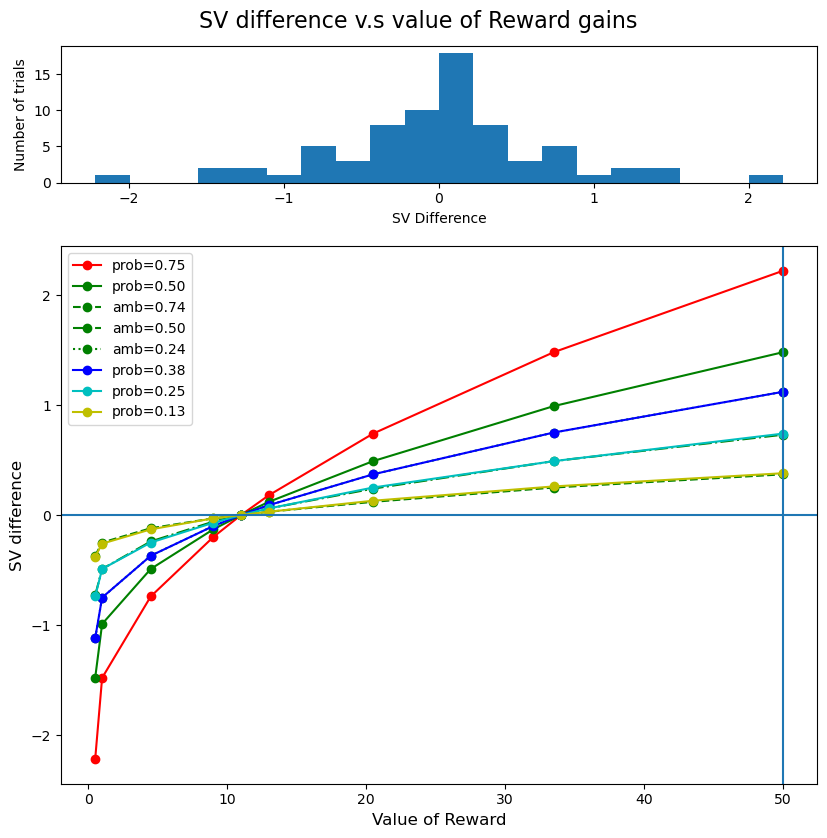

In [105]:
from matplotlib.gridspec import GridSpec
import sys

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df,xvline=50,trials='gains'):

	# delta SV v.s value_reward
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward {}'.format(trials))

	colors = ['r','g','b','c','y','m','k']
	amb_line = ['--','-.',':']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		df_p = df.loc[(df['p_reward']==p) & (df['ambiguity']==A_null)]
		x,y = df_p['value_reward'],df_p['deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels
		if p==0.50:
			for j,A in enumerate(reversed(sorted(df['ambiguity'].unique()))):
				if A==0:
					continue
				df_A = df.loc[(df['p_reward']==p) & (df['ambiguity']==A)]
				x,y = df_A['value_reward'],df_A['deltaSV']
				ax.plot(x, y,'{0}o{1}'.format(colors[i],amb_line[j]),label='amb={0:0.2f}'.format(A)) #The plot conecting prob levels
				
		

	# ax.plot([50],[],'r-')
	ax.axvline(x=xvline)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")

plot_scatter_hist(df_Trials_gains,xvline=50)



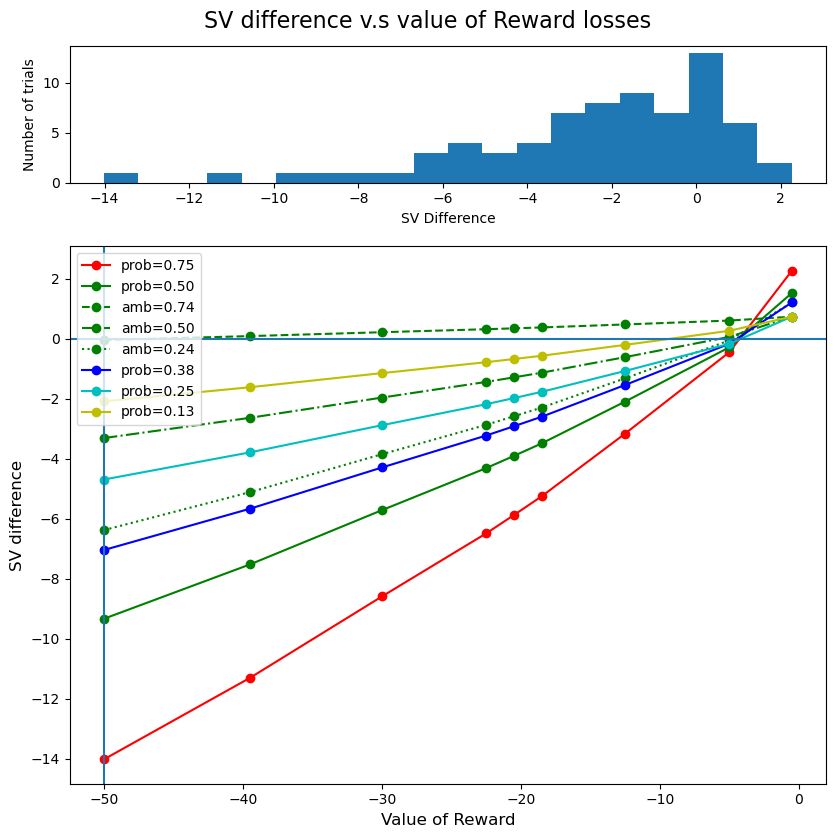

In [106]:
plot_scatter_hist(df_Trials_losses,xvline=-50,trials='losses')

# 5. The output CSV

In [107]:
#We define the list of image filenames. 
#For now, it is hardcoded. I need to work in soft coding it from 
#the participant's output csv 'crdm_img' column. 
 
   #risk images filenames
rimages = [ 'risk_blue_75.bmp','risk_blue_50.bmp', 'risk_blue_38.bmp','risk_blue_25.bmp', 'risk_blue_13.bmp',
           'risk_red_75.bmp','risk_red_50.bmp',  'risk_red_38.bmp', 'risk_red_25.bmp', 'risk_red_13.bmp']
    #Ambiguity images filenames
aimages = ['ambig_24.bmp', 'ambig_50.bmp','ambig_74.bmp']


p_options_100 = [int(p * 100) for p in p_options] #We define the probabilities as integers. This is to be consistent with the output csv format
risk_images = {} #Empty dict to store the results. 

for p in p_options_100: #Iterate through each probability
    #For each probability value, we start with an empty list named 
    # matching_images to hold the filenames that match the current probability 
    matching_images = [img for img in rimages if isinstance(img, str) and f"_{p}" in img]
    #For each image filename, we check if it's a string 
    # and if the formatted probability (like "_75") is present in the filename.
    #If both conditions are true, the image filename is added to the list. 
    risk_images[p] = matching_images #After iterating through the file names,we assign the list
    #to the risk_images dictionary using p as a key. 


amb_options = [0.24, 0.5, 0.74]
amb_options_100 = [int(a * 100) for a in amb_options]
amb_images = {}

for a in amb_options_100:
    matching_images = [img for img in aimages if isinstance(img, str) and f"ambig_{a}" in img]
    amb_images[a] = matching_images



In [108]:

#Making it into the raw CSV
raw_trials = 'csv/{}_raw_trials.csv'.format(patient_code)
df_trials = pd.concat([df_Trials_gains,df_Trials_losses])
df_trials.to_csv(raw_trials,float_format='%.2f',index=False)
pd.read_csv(raw_trials)

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_safe,deltaSV
0,Extr_pos,0.75,50.0,0.00,4.44,2.22,6.0,2.220000
1,Extr_pos,0.50,50.0,0.00,2.96,1.48,2.5,1.480000
2,Extr_pos,0.38,50.0,0.00,2.25,1.12,1.5,1.120000
3,Extr_pos,0.25,50.0,0.00,1.48,0.74,0.5,0.740000
4,Extr_pos,0.13,50.0,0.00,0.77,0.38,0.5,0.380000
5,Extr_pos,0.50,50.0,0.24,2.24,1.12,1.5,1.120000
6,Extr_pos,0.50,50.0,0.50,1.46,0.73,0.5,0.730000
7,Extr_pos,0.50,50.0,0.74,0.74,0.37,0.5,0.370000
8,Zero_Reward,0.75,0.5,0.00,0.00,2.22,6.0,-2.220000
9,Zero_Reward,0.50,0.5,0.00,0.00,1.48,2.5,-1.480000


In [109]:
#Let's reformat to match the psychopy CSV input
crdm_trials_gains = df_Trials_gains.copy()

crdm_trials_gains['category'] = 'gain'
crdm_trials_gains = crdm_trials_gains.sort_values('p_reward', ascending=True).reset_index(drop=True)
crdm_trials_gains = crdm_trials_gains.drop(columns=['SV_reward', 'SV_New_Safe','deltaSV'])
crdm_trials_gains['ambiguity'] = (crdm_trials_gains['ambiguity']*100).astype(int)
crdm_trials_gains['p_reward'] = (crdm_trials_gains['p_reward']*100).astype(int)
crdm_trials_gains = crdm_trials_gains.rename(columns={
    'value_safe':'crdm_sure_amt',
    'value_reward':'crdm_lott',
    'ambiguity': 'crdm_amb_lev',
    'p_reward':'crdm_lott_p', 
    'category':'crdm_domain'})
crdm_trials_gains['crdm_sure_p'] = 100
# Reordering columns
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_gains = crdm_trials_gains[column_order]

# Sort the DataFrame first by 'crdm_lott_p' and then by 'crdm_amb_lev
crdm_trials_gains = crdm_trials_gains.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=[True,True])

# Separate rows with 'crdm_amb_lev' different from zero to the end
zero_ambiguity_rows = crdm_trials_gains[crdm_trials_gains['crdm_amb_lev'] == 0]
non_zero_ambiguity_rows = crdm_trials_gains[crdm_trials_gains['crdm_amb_lev'] != 0]

# Concatenate the DataFrames to put rows with 'crdm_amb_lev' different from zero at the end
crdm_trials_gains = pd.concat([zero_ambiguity_rows, non_zero_ambiguity_rows], ignore_index=True)
crdm_trials_gains

,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain
0,0.5,100,1.0,13,0,gain
1,0.5,100,33.5,13,0,gain
2,0.5,100,20.5,13,0,gain
3,0.5,100,50.0,13,0,gain
4,0.5,100,9.0,13,0,gain
5,0.5,100,4.5,13,0,gain
6,0.5,100,11.0,13,0,gain
7,0.5,100,0.5,13,0,gain
8,0.5,100,13.0,13,0,gain
9,0.5,100,33.5,25,0,gain


In [110]:
# Randomly assign values to crdm_lott_top or crdm_lott_bot
# randomly select whether each value should go to the crdm_lott_top or crdm_lott_bot column
random_assignments = np.random.choice(['crdm_lott_top', 'crdm_lott_bot'], size=len(crdm_trials_gains))

# np.where to conditionally assign values from the crdm_lott column to the appropriate 
# columns based on the random selections
crdm_trials_gains['crdm_lott_top'] = np.where(random_assignments == 'crdm_lott_top', crdm_trials_gains['crdm_lott'], 0)
crdm_trials_gains['crdm_lott_bot'] = np.where(random_assignments == 'crdm_lott_bot', crdm_trials_gains['crdm_lott'], 0)

column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_gain = crdm_trials_gains[column_order]

##Losses


#Let's reformat to match the psychopy CSV input
crdm_trials_losses = df_Trials_losses.copy()
crdm_trials_losses = crdm_trials_losses.sort_values('p_reward', ascending=True).reset_index(drop=True)
crdm_trials_losses['category'] = 'loss'
crdm_trials_losses = crdm_trials_losses.drop(columns=['SV_reward', 'SV_New_Safe','deltaSV'])
crdm_trials_losses['ambiguity'] = (crdm_trials_losses['ambiguity']*100).astype(int)
crdm_trials_losses['p_reward'] = (crdm_trials_losses['p_reward']*100).astype(int)
crdm_trials_losses = crdm_trials_losses.rename(columns={
    'value_safe':'crdm_sure_amt',
    'value_reward':'crdm_lott',
    'ambiguity': 'crdm_amb_lev',
    'p_reward':'crdm_lott_p', 
    'category':'crdm_domain'})
crdm_trials_losses['crdm_sure_p'] = 100
# Reordering columns
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_losses = crdm_trials_losses[column_order]
#crdm_trials_losses =crdm_trials_losses.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=True).reset_index(drop=True)

# Sort the DataFrame first by 'crdm_lott_p' and then by 'crdm_amb_lev
crdm_trials_losses = crdm_trials_losses.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=[True,True])

# Separate rows with 'crdm_amb_lev' different from zero to the end
zero_ambiguity_rows_loss = crdm_trials_losses[crdm_trials_losses['crdm_amb_lev'] == 0]
non_zero_ambiguity_rows_loss = crdm_trials_losses[crdm_trials_losses['crdm_amb_lev'] != 0]

# Concatenate the DataFrames to put rows with 'crdm_amb_lev' different from zero at the end
crdm_trials_losses = pd.concat([zero_ambiguity_rows_loss, non_zero_ambiguity_rows_loss], ignore_index=True)

# Randomly assign values to crdm_lott_top or crdm_lott_bot
# randomly select whether each value should go to the crdm_lott_top or crdm_lott_bot column
random_assignments = np.random.choice(['crdm_lott_top', 'crdm_lott_bot'], size=len(crdm_trials_losses))

# np.where to conditionally assign values from the crdm_lott column to the appropriate 
# columns based on the random selections
crdm_trials_losses['crdm_lott_top'] = np.where(random_assignments == 'crdm_lott_top', crdm_trials_losses['crdm_lott'], 0)
crdm_trials_losses['crdm_lott_bot'] = np.where(random_assignments == 'crdm_lott_bot', crdm_trials_losses['crdm_lott'], 0)

column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_loss = crdm_trials_losses[column_order]


#Joining the 2 trials 
crdm_trials = pd.concat([crdm_trials_gain,crdm_trials_loss],ignore_index=True)

Creating the crdm_win_side column

In [111]:
def determine_win_side(row): #Function the determine the wining side of the lottery. 
    if row['crdm_lott_top'] != 0.00:
        return 'top'
    else:
        return 'bottom'
    
# Apply the function to create the 'crdm_win_side' column
crdm_trials['crdm_win_side'] = crdm_trials.apply(determine_win_side, axis=1)
#crdm_trials

#Function to created crdm_image
def determine_risk_image_file(row):
    for p, f in risk_images.items():
        if row['crdm_lott_p'] == p and row['crdm_win_side'] == 'top':
            return  f[1] #using the 2nd item in the dictionary for red images
        elif row['crdm_lott_p'] == p and row['crdm_win_side'] == 'bottom':
            return f[0] #Using the first item of the dict as blue
crdm_trials['crdm_img'] = crdm_trials.apply(determine_risk_image_file,axis =1)

column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain', 'crdm_img', 'crdm_win_side']
crdm_trials = crdm_trials[column_order]

#Rounding to the nearest 50 cents

crdm_trials

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_img,crdm_win_side
0,0.5,100,1.0,0.0,13,0,gain,risk_red_13.bmp,top
1,0.5,100,33.5,0.0,13,0,gain,risk_red_13.bmp,top
2,0.5,100,0.0,20.5,13,0,gain,risk_blue_13.bmp,bottom
3,0.5,100,50.0,0.0,13,0,gain,risk_red_13.bmp,top
4,0.5,100,0.0,9.0,13,0,gain,risk_blue_13.bmp,bottom
5,0.5,100,0.0,4.5,13,0,gain,risk_blue_13.bmp,bottom
6,0.5,100,0.0,11.0,13,0,gain,risk_blue_13.bmp,bottom
7,0.5,100,0.5,0.0,13,0,gain,risk_red_13.bmp,top
8,0.5,100,13.0,0.0,13,0,gain,risk_red_13.bmp,top
9,0.5,100,0.0,33.5,25,0,gain,risk_blue_25.bmp,bottom


In [113]:
crdm_trials_csv = 'csv/{}_adaptive_trials.csv'.format(patient_code)
crdm_trials.to_csv(crdm_trials_csv,float_format='%.2f',index=False)
#pd.read_csv(crdm_trials_csv)

![Alt text](https://i.pinimg.com/736x/f3/6c/11/f36c119a1229c67741fca443fc97de6d.jpg)